
# Experiment for a repeating and integration 

In [1]:
import math
from datetime import datetime, timedelta
from fractions import Fraction
from e3d.commanding import (
    Experiment,
    Frequency,
    BeamPointing,
    Timing,
    Code,
    Polarization,
    Polarity,
    Decimation,
    RangeExtent,
    __version__
)
print(__version__)

2.22.0


In [2]:
from astropy.coordinates import EarthLocation,SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import AltAz
from datetime import datetime
import calendar
import numpy as n
import matplotlib.pyplot as plt
lat=68.26710588564383
lon=19.44816239437641


d = datetime.utcnow()
unixtime = calendar.timegm(d.utctimetuple())

observing_location = EarthLocation(lat=lat*u.deg, lon=lon*u.deg, height=100*u.m)  

pointings=[]
names=[]#"zenith","casa","cyga"]
area_scales=[]

bp = BeamPointing(az=0, el=90, degrees=True)
pointings.append(bp)
area_scales.append(1.0)
names.append("zenith")
cas_a = {"RA":"23h23m24s","Dec":"+58d48.9m"}
cyg_a = {"RA":"19h59m28s","Dec":"+40d44m02s"}

cas_a_c = SkyCoord(cas_a["RA"], cas_a["Dec"])
cyg_a_c = SkyCoord(cyg_a["RA"], cyg_a["Dec"])


d = datetime.utcnow()
unixtime = calendar.timegm(d.utctimetuple())
delta_t=10
observing_time = Time(unixtime+delta_t,format="unix") 
print(observing_time)
aa = AltAz(location=observing_location, obstime=observing_time)
cas_a_aa=cas_a_c.transform_to(aa)
cyg_a_aa=cyg_a_c.transform_to(aa)

casp={}
casp["az"]=cas_a_aa.az.deg
casp["el"]=cas_a_aa.alt.deg
names.append("casa")

print(casp)
bp = BeamPointing(az=casp["az"], el=casp["el"], degrees=True)
pointings.append(bp)
area_scales.append(n.sin(n.pi*casp["el"]/180.0))

cygp={}
cygp["az"]=cyg_a_aa.az.deg
cygp["el"]=cyg_a_aa.alt.deg
# don't do cyg-a if lower than 30 degrees
if cygp["el"] > 23.0:
    bp = BeamPointing(az=cygp["az"], el=cygp["el"], degrees=True)
    pointings.append(bp)
    area_scales.append(n.sin(n.pi*cygp["el"]/180.0))
    names.append("cyga")

print(pointings)
# I don't know what the gain is in each direction, but my best guess is that it scales with 1/sin(elevation)
print(area_scales)
print(names)

1716991181.0
{'az': 325.0215670002552, 'el': 43.15128540641583}
[(az=0°, el=90°) [0° := N, CW], (az=325.0215670002552°, el=43.15128540641583°) [0° := N, CW]]
[1.0, 0.6839270675429941]
['zenith', 'casa']


In [3]:

#import e3dlib_upgrade.main

# System noise calibration theory

We use radio stars with known radio fluxes to estimate system noise. 

Link to De Baars [https://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1977A%26A....61...99B&defaultprint=YES&filetype=.pdf]

The thesis appendix of Derek McKay, page 222 [https://munin.uit.no/handle/10037/13716] contains useful equations and theory. 

One Jansky is a unit in radio astronomy that translates to SI units as follows
Jy = $10^{-26}$ W/m$^2$/Hz


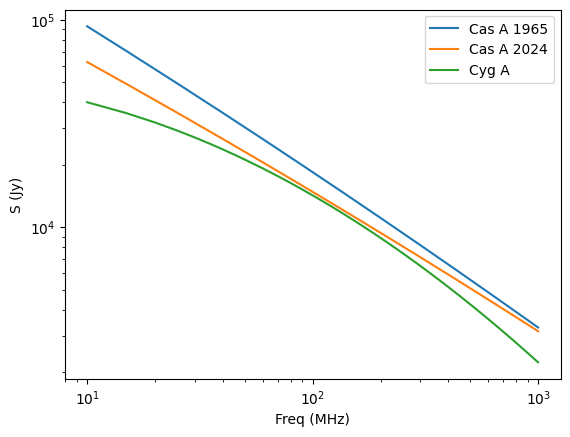

In [4]:
# De Baars et.al., A-list fluxes https://adsabs.harvard.edu/full/1977A%26A....61...99B

freqs_MHz=n.linspace(10,1000,num=200)

#age_factor=(1-cas_a_decrease_per_year/100.0)**n_years
def cas_a_spec(nu,year=1965):
    n_years=year-1965
    cas_a_decrease_per_year = 0.97 - 0.3*n.log10(nu)
    age_factor=(1-cas_a_decrease_per_year/100.0)**n_years
    return(age_factor*10**(5.625 - 0.634*n.log10(nu) - 0.023*(n.log10(nu))**2.0))
def cyg_a_spec(nu):
    return(10**(4.695 + 0.085*n.log10(nu) - 0.178*(n.log10(nu))**2.0))
    
plt.loglog(freqs_MHz,cas_a_spec(freqs_MHz,year=1965),label="Cas A 1965")
plt.loglog(freqs_MHz,cas_a_spec(freqs_MHz,year=2024),label="Cas A 2024")
plt.loglog(freqs_MHz,cyg_a_spec(freqs_MHz),label="Cyg A")
plt.legend()
plt.xlabel("Freq (MHz)")
plt.ylabel("S (Jy)")
plt.show()



In [5]:
rx_freq = Frequency(229.125, "MHz")  #229.125 for calibration generator
# for some reason, the transmit and receive frequency are offset by 200 kHz. 
# is this exact? Why is there an offset? Could this offset be hidden. If
# you request 233 MHz, one would expect the system to be tuned to 233 MHz. 
tx_freq = Frequency(229.125-0.2, "MHz")
# 104 MHz sample-rate 104 decimate => 1 MHz sample-rate
decimation = Decimation(104)
sample_factor=1
#decimation = Decimation(104)


# 7 module receiver
# could this be e.g., pet?
site_rx = "pet"
# 1 module transmitter
site_tx = "pet"

# beam pointing
radar_az=0
radar_el=70

#bp = BeamPointing(az=radar_az, el=radar_el, degrees=True)


# this is an interval of time used by this experiment

# define time slice
# this is a 100 us pulse? "pulse_n_0.0001"
# "pulse_n_3e-05" is a <10 us pulse
n_pulses=200
ipp=1000
nbeams = 1
frames = len(pointings)
nrep=1

# create new experiment
expr = Experiment(name="test_integration")
# add an instruction to the experiment
# what should radar do
ins = expr.add_instruction()
# repeat a cycle nrep times. "B" is an id that refers to a timing
cyc = ins.add_cycle().iterate(Timing("B", nrep))  

nsamples=n_pulses*ipp*sample_factor
# 104
#code_name="barker13_4u_200kHz"   #barker13_4u_200kHz
code_name="pulse_n_3e-05"
decode_barker=False

# Repeat pulses using different widebeams, will do loadbalacing as data goes to different pipeline.
for frame_idx in range(frames):
    for ibeam in range(nbeams):    
        ts = cyc.add_timeslice(timing=Timing("A"))
        for pulse_idx in range(n_pulses):
        #    print(Timing(timedelta(microseconds=pulse_idx*ipp+pulse_idx*0.0 + 20), ref=ts))
            tx = ts.add_transmission(
                site=site_tx, # what is the transmitter
                # timing relative to start of slice
                timing=Timing(timedelta(microseconds=pulse_idx*ipp+pulse_idx*0.435 + 20), ref=ts), 
                beam_pointing=pointings[0], # always zenith
                code=Code(code_name, 0),   # reference to library of pulses      
                # phase difference between X and Y linear polarizations
                polarization=Polarization(90.),   
                carrier_frequency=tx_freq,
                rx_end=Timing(timedelta(microseconds=pulse_idx*ipp+ipp-100), after=ts)
            )
    
        # az and el offset from wide beam boresight direction
        narrow_beam_pointings = [BeamPointing.from_offset(az=0, el=0, degrees=True)]
        
        # receive definition
        # for each receiver wide beam (up to 10 possible)
        print(pointings[frame_idx])
            # each rx antenna polarization
        for polarity in Polarity.A:
            rx = ts.add_reception(
                site=site_rx,
                timing=Timing(timedelta(microseconds=0), ref=ts),
                polarity=polarity,
                wide_beam_index=ibeam,
                wide_beam_pointing=pointings[frame_idx],
                nsamples=nsamples,
                center_frequency=rx_freq,
                decimation=decimation
            )
            # second stage beamformer
            ssbf = ts.add_ssbf(
                site=site_rx,
                input=rx.output,
                narrow_beam_pointings=narrow_beam_pointings
            )
            # 
            ssbf.output.note.update(
                az=bp.az_deg,
                el=bp.el_deg,
            )
        # we add one more time slice to indicate that radar
        # control ends.
        cyc.add_timeslice(Timing("A"))  # sentinel
        
        # add a definition of computation pipeline
        comp = ins.add_computation()
        
        # hard target filter, copy this process and insert it at the output of
        # the ssbf like this:
        for ssbf_output in cyc.output.unused:
            hter = comp.add_hter(site=site_rx, input=ssbf_output, nout=nrep)
            hter.output.note.update(**ssbf_output.note)
        
        # get tuples
        for (beam, pol, idx), outputs in comp.output.unused.groupby(("beam", "polarity", "index")):
            az = [output.note["az"] for output in outputs]
            el = [output.note["el"] for output in outputs]
        
            comp.add_export(
                site=site_rx,
                input=hter.output,
                parameters={
                    "frame_idx": frame_idx,
                    "nsamples": nsamples,
                    "polarity": pol,
                    "az": az,
                    "el": el,
                    "ib": beam,
                    "idx": idx,
                    "frame_idx": frame_idx,
                    "type": "passthrough",
                })



(az=0°, el=90°) [0° := N, CW]
(az=325.0215670002552°, el=43.15128540641583°) [0° := N, CW]


/tmp/ipykernel_258480/1675146682.py:61: UserWarning: Unknown code name: 'pulse_n_3e-05'.
  code=Code(code_name, 0),   # reference to library of pulses
/tmp/ipykernel_258480/1675146682.py:65: UserWarning: `after` is deprecated, use ref instead.
  rx_end=Timing(timedelta(microseconds=pulse_idx*ipp+ipp-100), after=ts)


In [6]:
# note entirely sure what A and B is

# add all the defined computations
op = expr.add_operation(ins)

slice_length = n_pulses*ipp
expr.resolve_timing(
    A=timedelta(seconds=0.21),
    B=timedelta(seconds=20)
    )
# send experiment to database 
expr.commit()


    

Experiment({'created_at': '2024-05-29T13:59:33.515076', 'created_by': '07731657-7449-43e2-81b6-405a8971399b', 'name': 'test_integration', 'status': 'pending', 'uuid': 'bce7956e-1f08-4341-a004-28a0c5442ec1'})

In [7]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(10, 6))
#ins.plot_pointing()
#plt.tight_layout()

#plt.figure(figsize=(10, 6))
#ins.plot_timing()
#plt.tight_layout()

In [8]:
#for i in range(10):
# request radar to run the experiment after 10 seconds
op.set_start_time(after=timedelta(seconds=40))
op.commit()


Operation(idx=0) @ Experiment(id='bce7956e-1f08-4341-a004-28a0c5442ec1') [2 products]

  0%|          | 0/2 [00:00<?, ? files/s, ETA=2024-05-29 14:00:14]

/e3d/data/2024/May/29/115029483.bin
WBeam idx 0 (200, 1000) (-1-3j) (-1.4873084-1.4917166j) 

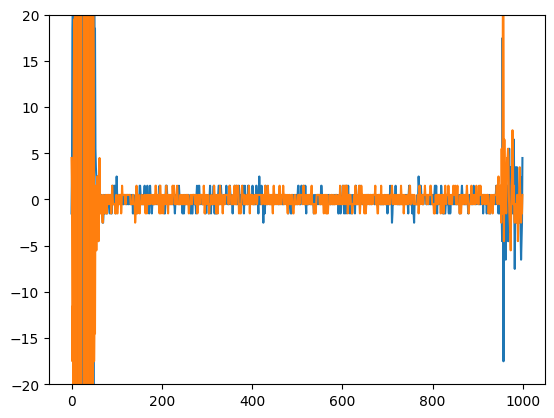

1.0135703086853027
dc offset -1,-1 noise std 0.71


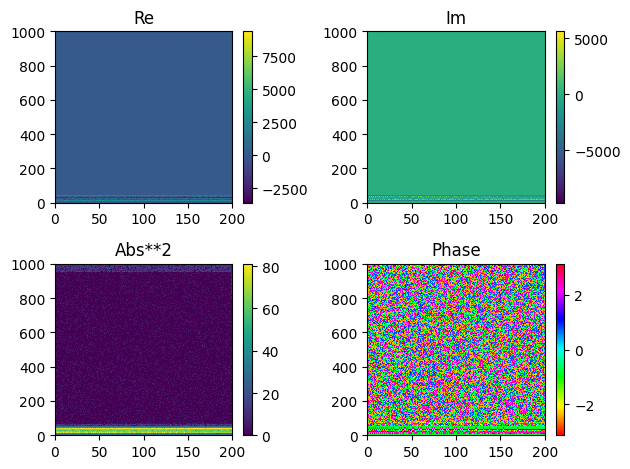

/e3d/data/2024/May/29/115029486.bin
WBeam idx 0 (200, 1000) (-1-3j) (-1.4886583-1.4843j) 

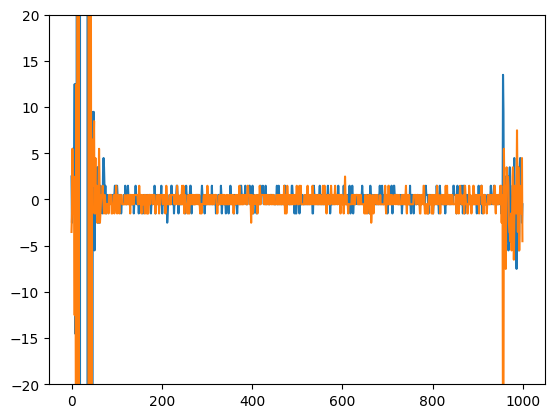

2.248802879572376
dc offset -1,-1 noise std 0.71


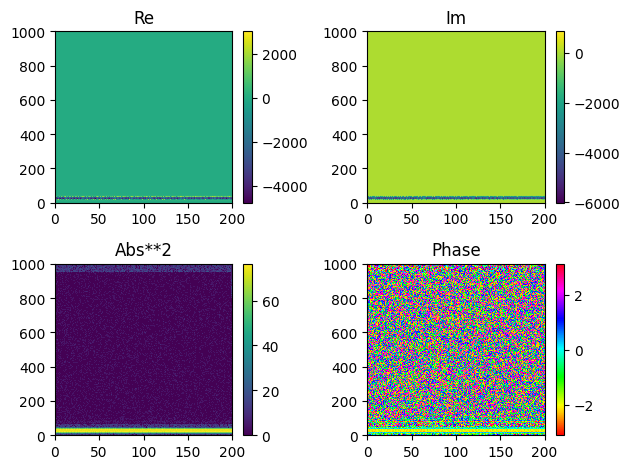

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from e3d.ext.par import dB
import numpy as n
import scipy.constants as c

S = n.zeros((n_pulses,ipp),dtype=n.float32)
Z=n.zeros((n_pulses,ipp),dtype=n.complex64)
sr=decimation.sample_clock_MHz
range_gates_km=n.arange(ipp)*0.15
doppler=n.fft.fftshift(n.fft.fftfreq(n_pulses,d=ipp/1e6))


code=n.array([+1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1],dtype=n.complex64)
code4=n.repeat(code,4)
CODE=n.conj(n.fft.fft(code4,ipp))

Z_prev=Z
powers=n.zeros(len(pointings))
for prod in op.wait(timeout=timedelta(seconds=60)):
    if prod:
        print(prod.path)
        if prod.metadata["type"] == "passthrough":
            print("WBeam idx", prod.metadata["ib"], end=" ")
            Z=prod.data
            Z.shape=(n_pulses,ipp)


            print(Z.shape, end=" ")
            Z.shape=(n_pulses,ipp)
            print(n.median(Z), end=" ")
            dc_offset=n.nanmean(Z[:,200:800])
            print(dc_offset, end=" ")
            Z=n.array(Z,dtype=n.complex64)
            Z=Z-dc_offset

            plt.plot(Z[0,:].real)
            plt.plot(Z[0,:].imag)
            plt.ylim([-20,20])
            plt.show()
            
            frame_idx=prod.metadata["frame_idx"]
            powers[frame_idx]=n.mean(n.abs(Z[:,200:800])**2.0)/area_scales[frame_idx]
            print(powers[frame_idx]/area_scales[frame_idx])
            std_est=n.nanmedian(n.abs(Z))
            print("dc offset %d,%d noise std %1.2f"%(n.real(dc_offset),
                                                     n.imag(dc_offset),
                                                     std_est))
            
            #Z=Z-dc_offset
            if decode_barker:
                for ti in range(n_pulses):
                    Z[ti,:]=n.fft.ifft(n.fft.fft(Z[ti,:])*CODE)
                
            for ri in range(ipp):
                S[:,ri]+=n.abs(n.fft.fftshift(n.fft.fft(Z[:,ri])))**2.0


            plt.subplot(221)
            plt.pcolormesh(Z[:,0:1000].real.T)
            plt.title("Re")
            plt.colorbar()
            plt.subplot(222)
            plt.pcolormesh(Z[:,0:1000].imag.T)
            plt.title("Im")
            plt.colorbar()
            plt.subplot(223)
            plt.pcolormesh(10.0*n.log10(n.abs(Z[:,0:1000].T)**2.0),vmin=0)
            plt.title("Abs**2")
            plt.colorbar()
            plt.subplot(224)
            plt.pcolormesh(n.angle(Z[:,0:1000].T),cmap="hsv")
            plt.title("Phase")
            plt.colorbar()
            plt.tight_layout()
            plt.show()


    else:
        print(prod.label)






# System noise temperature

Note that KAIRA had SEFD of around 2 kJy for 233 MHz. The antenna was not very efficient at that frequency though. See Fig 11 in McKay-Bukowski et.al., 2014):

McKay-Bukowski, Derek, et al. "KAIRA: The Kilpisjärvi atmospheric imaging receiver array—System overview and first results." IEEE Transactions on Geoscience and Remote Sensing 53.3 (2014): 1440-1451.








In [10]:
import scipy.constants as c
E3D_casa = cas_a_spec(233,year=2024)
print(E3D_casa)
E3D_cyga = cyg_a_spec(233)
#print(E3D_cyga)

SEFD_casa=E3D_casa*powers[0]/(powers[1]-powers[0])
if len(powers) == 3:
    SEFD_cyga=E3D_cyga*powers[0]/(powers[2]-powers[0])
#print(SEFD_casa)
#print(SEFD_cyga)

#print("SEFD Cas-A %1.2f Cyg-A %1.2f (Jy)"%(SEFD_casa,SEFD_cyga))

# I don't know what the effective area of the PET system is. I'm assuming that it is a circle with a 5 meter radius
A_eff= 20
# I'm assuming PET antenna peak gain is 23 dB in zenith
G=10**(23/10)
lam=c.c/244e6
A_eff = (lam**2.0/(4.0*n.pi))*G
print("A_eff %1.2f (m^2)"%(A_eff))

T_sys_casa= SEFD_casa*1e-26*A_eff/2/c.k
if len(powers) == 3:
    T_sys_cyga= SEFD_cyga*1e-26*A_eff/2/c.k

print("Elevation angle corrected power ratios Pzenith/Pcasa %1.2f"%(powers[0]/powers[1]))
print("SEFD Cas-A %1.2f (Jy)"%(SEFD_casa))
print("Tsys Cas-A %1.2f (K)"%(T_sys_casa))

if len(powers) == 3:
    print("Elevation angle corrected power ratios Pzenith/Pcyga %1.2f"%(powers[0]/powers[2]))
    print("SEFD Cyg-A %1.2f (Jy)"%(SEFD_cyga))
    print("Tsys Cyg-A %1.2f (K)"%(T_sys_cyga))


8482.841120417866
A_eff 23.97 (m^2)
Elevation angle corrected power ratios Pzenith/Pcasa 0.66
SEFD Cas-A 16394.33 (Jy)
Tsys Cas-A 142.31 (K)
